# QAOA Braket

In [1]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.timings import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
from braket.aws import  AwsQuantumTask

from quera_ahs_utils.plotting import (
    show_global_drive,
    show_register
)


import numpy as np
import networkx as nx
from collections import defaultdict
import json

In [2]:
def cost_function(x, G):
    obj = 0
    for i, j in G.edges():
        if x[i] + x[j] == "11":
            obj += 2
    return - x.count("1") + obj

In [3]:
backends = {}
backends["quera_aquila"] = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
backends["braket_emulator"] = LocalSimulator("braket_ahs")

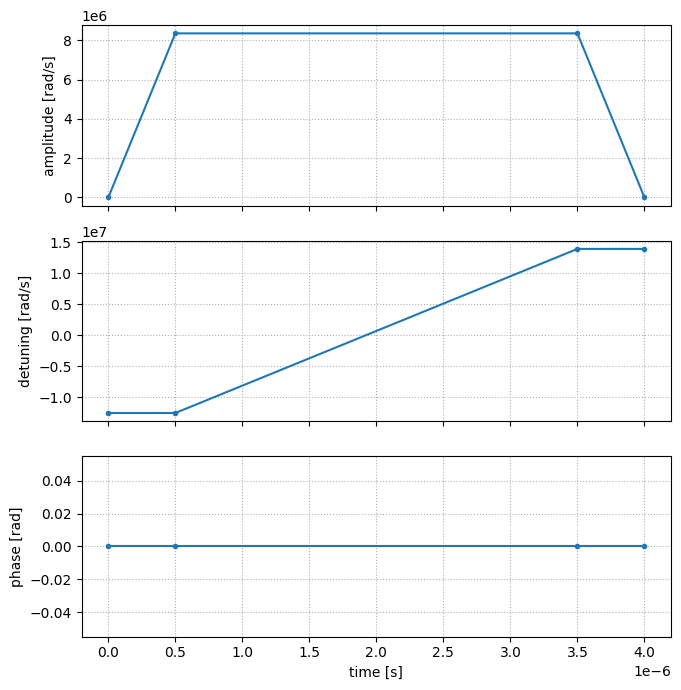

In [4]:
# Prepare Schedule (Independent of the problem size)

Omega_annealing = 1.33*2*np.pi*1e6
Delta_g_0 = -2.*2*np.pi*1e6
Delta_g_annealing = 2.22*2*np.pi*1e6#3.75*2*np.pi*1e6

t_sweep = 3.0e-6
t_ramp = 0.5e-6
t_delay = 0.#round(1.95e-6,9)

t0 = t_delay
t1 = t0+t_ramp
t2 = t1 + t_sweep
t3 = t2 +t_ramp

omegas = [0,0,Omega_annealing,Omega_annealing,0.]
deltas = [Delta_g_0,Delta_g_0,Delta_g_0,Delta_g_annealing,Delta_g_annealing]
phis = len(omegas) * [0]

times = [0 , t0,t1,t2,t3]

Omega = TimeSeries.from_lists(times, omegas)
Delta = TimeSeries.from_lists(times, deltas)
phi = TimeSeries.from_lists(times, phis)

drive = DrivingField(
    amplitude=Omega,
    phase=phi,
    detuning=Delta
)
show_global_drive(drive)

In [20]:
# Prepare Register

nq = 11
with open(f"./Data/problems/{nq}.json", "r") as file:
    problem = json.load(file)

G = nx.Graph()
G.add_nodes_from(range(nq))
G.add_edges_from(problem["edges"])
problem.keys()
register = AtomArrangement()
a = 6.79e-6
grid_side = problem["grid_side"]
pos = problem["pos"]
numx,numy = [grid_side,grid_side]
x_shift = a * (numx - 1) / 2
y_shift = a * (numy - 1) / 2
pos_dict = {}
for i, pos_i in enumerate(pos):
    register.add([round(pos_i[0] * a - x_shift,8), round(pos_i[1] * a - y_shift,8)])    
# show_register(register, blockade_radius = np.sqrt(2)*a)

# Prepare Hamiltonian
ahs_program = AnalogHamiltonianSimulation(
    hamiltonian=drive,
    register=register
)

# show_global_drive(drive)

In [21]:
# Run experiment
shots = 200
result = {}
backend_name = "braket_emulator"
#backend_name = "quera_aquila"
job = backends[backend_name].run(ahs_program, shots=shots)
if backend_name == "braket_emulator":
    res = job.result()
    dict_counts = defaultdict(int)
    for k, count in res.get_counts().items():
        dict_counts["".join("1" if s == "r" else "0" for s in k)] += count
    result["samples"] = dict_counts
elif backend_name == "quera_aquila":
    arn = job.id
    result['arn'] = arn
result["shots"] = shots
with open(f"./Data/{backend_name}/{nq}.json", "w") as file:
    json.dump(result, file)


In [22]:
# Postprocessing
nq = 11
backend_name = "braket_emulator"
#backend_name = "quera_aquila"
with open(f"./Data/{backend_name}/{nq}.json", "r") as file:
    result = json.load(file)

with open(f"./Data/problems/{nq}.json", "r") as file:
    problem = json.load(file)
G = nx.Graph()
G.add_nodes_from(range(nq))
G.add_edges_from(problem["edges"])

if backend_name == "quera_aquila":
    arn = result['arn']
    res = AwsQuantumTask(arn = arn).result()
    dict_counts = defaultdict(int)
    dict_counts_1 = defaultdict(int)
    defects = 0
    for k, count in res.get_counts().items():
        if not "e" in k:
            dict_counts["".join("1" if s == "r" else "0" for s in k)] += count
        else:
            defects += 1
    result["samples"] = dict_counts
    
cost_evals = defaultdict(int)
for k, v in result["samples"].items():
    cost = cost_function(k, G)
    cost_evals[cost] += v
result["cost"] = cost_evals
if backend_name == "quera_aquila":
    result["defects"] = defects
    print(f"Number of samples with defects: {defects}")
    
result["min_cost"] = cost_function(problem["sol"], G)

with open(f"./Data/{backend_name}/{nq}.json", "w") as file:
    json.dump(result, file)